## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import json
import math
import random
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, matthews_corrcoef

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW, SGD
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer, Trainer, TrainingArguments,AutoTokenizer, BertForPreTraining
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput


## Read Dataset

In [3]:
#df = pickle.load(open('dataset/230130_SmallOberkategorie.pickle', 'rb'))
df = pd.read_pickle("gs://transformer-textclassification/230130_testdata.pickle")
label_names = df['labels'].unique()
label_names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int8)

# Data Preprocessing
## Train Test Split

In [4]:
def split_df(X, y):    

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

    fig, axes = plt.subplots(figsize=(12,4),nrows=1, ncols=2)

    ax1=axes[0]
    y_train.value_counts().plot(ax= ax1, kind='bar')
    ax1.set_title("Class Distribution in the Train Set")
    ax1.set_xlabel("Label")
    ax1.set_ylabel("Count")


    ax2=axes[1]
    y_val.value_counts().plot(ax=ax2, kind='bar')
    ax2.set_title("Class Distribution in the Test Set")
    ax2.set_xlabel("Label")
    ax2.set_ylabel("Count")
    plt.show()
    
    return X_train, X_val, y_train, y_val

## Tokenization

In [5]:
def tokenize(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
    return tokenizer

# uncommment this function in case of mot propoerly encode the model
# def tokenize(model_name):
#     try:
#         tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
#     except:
#         tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
#     return tokenizer

## Encode datasets

In [6]:
def encode(docs, tokenizer):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

## Process datasets

In [7]:
def preprocess_dataset(model_name, X, y, batch_size):
    # initialize tokenizer
    tokenizer = tokenize(model_name)
    
    # encode dataset with the tokenizer
    train_input_ids, train_att_masks = encode(X['text'].values.tolist(), tokenizer)

    
    # convert the labels into tensor
    train_y = torch.LongTensor(y.values.tolist())

    
    # convert the encoded dataset into dataloaders
    train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    
    return train_dataloader

# Transformer Models
## Model Creation

### Model without custom head

In [20]:
class CustomModel1(nn.Module):
    def __init__(self, checkpoint, num_labels, freeze_layers=True):
        super(CustomModel1, self).__init__()
        self.num_labels = num_labels
        
        # Load pre-trained model and freeze all layers except the classifier
        config = AutoConfig.from_pretrained(checkpoint, num_labels=num_labels)
        pretrain_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
        # pretrain_model = BertForPreTraining.from_pretrained(checkpoint, config=config)
        self.model = pretrain_model.bert
        
        for name, param in self.model.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = not freeze_layers
            

        
    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Feed input through the base model
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Extract the last hidden state and compute logits
        last_hidden_state = outputs.last_hidden_state[:, 0]
        logits = self.classifier(last_hidden_state)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss = outputs.loss
            logits = outputs.logits

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)


### Model with custom head

In [9]:
class CustomModel2(nn.Module):
    def __init__(self, checkpoint, num_labels, freeze_layers=True): 
        super(CustomModel2, self).__init__() 
        self.num_labels = num_labels 

        # Load Model with given checkpoint and extract its body
        config = AutoConfig.from_pretrained(checkpoint, num_labels=num_labels, output_attentions=True, output_hidden_states=True)
        pretrain_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
        # pretrain_model = BertForPreTraining.from_pretrained(checkpoint, config=config)
        self.model = pretrain_model.bert

        # Freeze all base model layers except the classification layer
        for name, param in self.model.named_parameters():
            if 'classifier' not in name:  # classifier layer should not be frozen
                param.requires_grad = not freeze_layers

        
        # Add custom layers
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.hidden_layer1 = nn.Linear(768, 512)
        self.hidden_layer2 = nn.Linear(512, 256)
        self.hidden_layer3 = nn.Linear(256, 768)
        self.classifier = nn.Linear(768, num_labels)
        
        
    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Extract outputs from the body
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        # Add custom layers
        sequence_output = self.dropout(outputs[0])  # outputs[0]=last hidden state
        hidden_output1 = self.activation(self.hidden_layer1(sequence_output))
        hidden_output2 = self.activation(self.hidden_layer2(hidden_output1))
        hidden_output3 = self.hidden_layer3(hidden_output2)
        final_output = self.dropout(hidden_output3)
        logits = self.classifier(final_output[:,0,:].view(-1, final_output.size(-1)))  # calculate losses

        loss = None
        if labels is not None:
        # set class weights here  
#           device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#           class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(device) # set weights here
            # self.model.classifier.weights = class_weights
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)


## Model Trainer
<span style='color:red'>P1<span>

In [11]:
def trainer(model, batch_size, optimizer, epochs, train_dataloader, valid_dataloader, val_steps):

    steps = 0
    train_acc_per_epoch = []
    train_loss_per_epoch = []
    val_acc_per_epoch = []
    val_loss_per_epoch = []
    
    # Set the seed for reproducibility
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                 num_warmup_steps=0,
                num_training_steps=len(train_dataloader)*epochs )

    
    train_loss = 0
    train_total_correct = 0
    train_total_examples = 0
    
    for epoch_num in range(epochs):
        print('Epoch: ', epoch_num + 1)
        '''
        Training
        '''
        model.train()

        for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            train_loss += loss.item()

            model.zero_grad()
            loss.backward()
            del loss

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            # update accuracy
            _, predicted = torch.max(output.logits, dim=1)
            train_total_correct += (predicted == labels).sum().item()
            train_total_examples += labels.size(0)            
            steps += 1
            
            '''
            Validation
            '''

            if steps >= val_steps:
                
                model.eval()
                val_total_correct = 0
                val_total_examples = 0
                valid_loss = 0
                valid_pred = []
                valid_label = []
                with torch.no_grad():
                    for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
                        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
                        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

                        loss = output.loss
                        valid_loss += loss.item()

                        valid_label.append(labels.cpu().detach().numpy())
                        valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

                        # update accuracy
                        _, predicted = torch.max(output.logits, dim=1)
                        val_total_correct += (predicted == labels).sum().item()
                        val_total_examples += labels.size(0)
                
                val_acc_per_epoch.append(val_total_correct / val_total_examples)
                val_loss_per_epoch.append(valid_loss / steps)
                
                valid_label = np.concatenate(valid_label)
                valid_pred = np.concatenate(valid_pred)
                
                print("{0}/{1} val accuracy: {2} ".format(steps, math.ceil(len(X_val) / batch_size), val_total_correct / val_total_examples))
                print("{0}/{1} val loss: {2} ".format(steps, math.ceil(len(X_val) / batch_size), valid_loss / steps))
                
                
                train_acc_per_epoch.append(train_total_correct / train_total_examples)
                train_loss_per_epoch.append(train_loss / steps)  

                print("{0}/{1} train accuracy: {2} ".format(steps, math.ceil(len(X_train) / batch_size), train_total_correct / train_total_examples))
                print("{0}/{1} train loss: {2} ".format(steps, math.ceil(len(X_train) / batch_size), train_loss / steps + 1))
                
                steps = 0
                train_loss = 0
                train_total_correct = 0
                train_total_examples = 0
    return model, train_acc_per_epoch, train_loss_per_epoch, val_acc_per_epoch, val_loss_per_epoch, valid_label, valid_pred

## Evaluation and Plotting

In [12]:
def plot_acc(epochs, train_acc_per_epoch, val_acc_per_epoch, model_name="Initial"):
    epochs_list = range(1, len(train_acc_per_epoch) +1 )
    fig, ax = plt.subplots()
    ax.plot(epochs_list,train_acc_per_epoch,label ='training accuracy')
    ax.plot(epochs_list,val_acc_per_epoch,label ='validation accuracy')
    ax.set_title('Training and Validation Accuracy of {} model'.format(model_name))
    ax.set_xlabel('Steps')
    ax.set_ylabel('Accuracy')
    ax.legend()
    img_url = 'figures/accuracy-train-' + model_name + '.png' 
    plt.savefig(img_url)
    plt.show()
    
def plot_loss(epochs, train_loss_per_epoch, val_loss_per_epoch, model_name="Initial"):
    epochs_list = range(1, len(train_loss_per_epoch) +1 )
    fig, ax = plt.subplots()
    ax.plot(epochs_list,train_loss_per_epoch,label ='train loss')
    ax.plot(epochs_list, val_loss_per_epoch, label = 'validation loss' )
    ax.set_title('Training and Validation Loss of {} model'.format(model_name))
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    ax.legend()
    img_url = 'figures/loss-train-' + model_name + '.png' 
    plt.savefig(img_url)
    plt.show()

In [13]:
def calculate_classification_reprot(label_names, val_label, valid_pred, model_name="Initial"):
    label_names_str = [str(x) for x in label_names]
    print('classifiation report of {} model'.format(model_name))
    print(classification_report(valid_pred, val_label, target_names=label_names_str))

In [14]:
def plot_confusion_matrix(y_preds, y_true, label_names, training=False, model_name="Initial"):
    label_names_str = [str(x) for x in label_names]
    cm = confusion_matrix(y_true, y_preds, normalize=None)
    
    index= 0
    data = []
    for row in cm:
        label = label_names[index]
        total_correct = row[index]
        total_count = row.sum()
        data.append([label, total_correct, total_count])
        index += 1
    
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ['Label', 'Correct_preds', 'Total_preds'])
    print(df)
    return df

In [15]:
def get_evaluation_results(y_test_set, predictions):
    #store results of model
    acc = accuracy_score(y_test_set, predictions)
    precision = precision_score(y_test_set, predictions,average='macro')
    recall = recall_score(y_test_set, predictions,average='macro')
    f1 = f1_score(y_test_set, predictions,average='macro')
    mcc = matthews_corrcoef(y_test_set, predictions)
    
    results = [round(acc, 4), round(precision, 4), round(recall, 4), round(f1, 4), round(mcc, 4)]
    return results

## Training

In [16]:
def training(models, configs, dataset):
    custom_head = configs['custom_head']
    freeze_layers = configs['freeze_layers']
    optimizers = configs['optimizers']
    epochs = configs['epochs']
    batch_sizes = configs['batch_sizes']
    learning_rates = configs['learning_rates']
    val_steps = configs['val_steps']
    
    custom_head_label = 'custom' if custom_head else 'base'
    model_function = CustomModel2 if custom_head else CustomModel1
    
    X_train, y_train, X_val, y_val = dataset.values() 
    
    # dic form store results of all models
    collect_train_results_of_all_model= {
        'Metrics':['accuracy','precision','recall','f1-score', 'MCC']
    }
    
    if os.path.exists(trained_models_file):
        with open(trained_models_file, 'r') as f:
            trained_models = [line.strip() for line in f]
            f.close()
    else:
        trained_models = []
            
    
    if os.path.exists(best_params_dict_path):
        with open(best_params_dict_path, 'r') as params_file:
            best_prams = json.load(params_file)
    else:
        best_prams = {}
    
    
    for model_name in models:    
        model_str = str(model_name).replace('/', '-')
        model_identifier = custom_head_label + '-' + model_str
        if best_prams.get(model_str) == None:
            best_prams[model_identifier] = dict.fromkeys(['best_acc', 'optimizer', 'epochs',
                            'batch_size', 'learning_rate'], 0.0)
            
        for batch_size in batch_sizes:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            train_dataloader = preprocess_dataset(model_name, X_train, y_train, batch_size)
            valid_dataloader = preprocess_dataset(model_name, X_val, y_val, batch_size)
            
            for optimizer_name in optimizers:
                for learning_rate in learning_rates:
                    for num_epochs in epochs:
                        
                        optimizer_str = str(optimizer_name).split('.')[-1].split("'")[0]
                        epoch_str = 'epoch' + str(num_epochs)
                        lr_str = 'lr' + str(learning_rate)
                        batch_size_str = 'batchsize' + str(batch_size)
                        model_variant = f'{custom_head_label}-{model_str}-{optimizer_str}-{epoch_str}-{lr_str}-{batch_size_str}-freeze-layer:{str(freeze_layers)}'
                        
                        model_url = 'models/' + model_identifier + '.pth'
                        
                        if model_variant in trained_models:
                            continue
                            
                        print("===========================================")
                        print(f"Hyperparameters: \n {optimizer_str, lr_str, batch_size_str, epoch_str} \n")
                        print("Start Training of {}".format(model_variant))
                        print("===========================================")
                        
                        
                        model = model_function(checkpoint=model_name, num_labels=len(label_names), freeze_layers=freeze_layers).to(device)
                        optimizer = optimizer_name(model.parameters(), lr=learning_rate)
                        if not freeze_layers:
                            model.load_state_dict(torch.load(model_url))
                        model, train_acc_per_epoch, train_loss_per_epoch, val_acc_per_epoch, val_loss_per_epoch, valid_label, valid_pred = trainer(model, batch_size, optimizer, num_epochs, train_dataloader, valid_dataloader, val_steps)

                        val_total_correct = (valid_label == valid_pred).sum().item()
                        val_acc =  val_total_correct/len(valid_label)
                        print(val_acc)
                        
                        plot_acc(num_epochs, train_acc_per_epoch, val_acc_per_epoch, model_variant)
                        plot_loss(num_epochs, train_loss_per_epoch, val_loss_per_epoch, model_variant)
                        correct_predictions_df = plot_confusion_matrix(valid_pred, valid_label, label_names, True, model_variant)
                        collect_train_results_of_all_model[model_variant] = get_evaluation_results(valid_label, valid_pred)
                        print("\n\n")
                        
                        with open(trained_models_file, 'a') as f:
                            f.write(f'{model_variant} \n')
                            
                        if val_acc > best_prams[model_identifier]['best_acc']:
                            best_prams[model_identifier]['best_acc'] = val_acc
                            best_prams[model_identifier]['optimizer'] = optimizer_str
                            best_prams[model_identifier]['epochs'] = num_epochs
                            best_prams[model_identifier]['batch_size'] = batch_size
                            best_prams[model_identifier]['learning_rate'] = learning_rate
                            best_prams[model_identifier]['custom_head'] = custom_head
                            best_prams[model_identifier]['freeze_layers'] = freeze_layers

                            with open(best_params_dict_path, "w") as fp:
                                json.dump(best_prams, fp)  # encode dict into JSON
                            torch.save(model.state_dict(), model_url)
                            csv_path = 'results/' + model_identifier + '.csv'
                            correct_predictions_df.to_csv()
        
    metrics_data_frame = pd.DataFrame.from_dict(collect_train_results_of_all_model, orient='index')
    print(tabulate(metrics_data_frame, tablefmt="fancy_grid")) # convert results in to table

## Configurations and Settings
<span style='color:red'>P2<span>

## Fine-tuning

### Running model without custom head and freeze layers

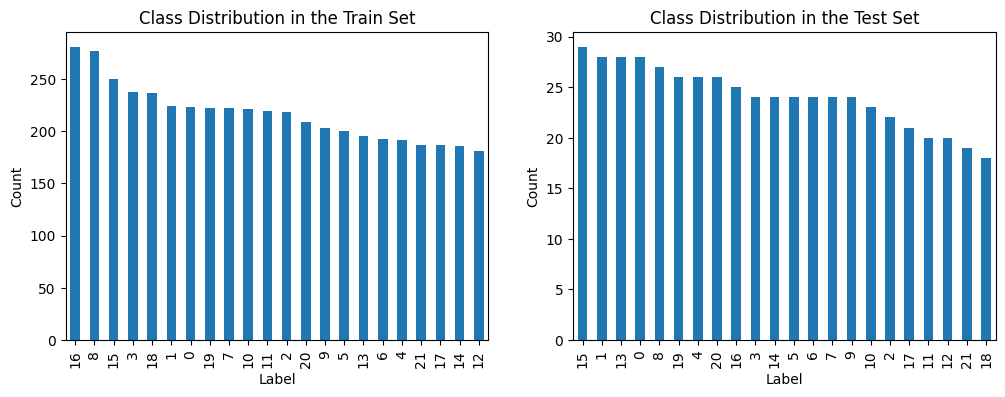

Hyperparameters: 
 ('Adam', 'lr5e-05', 'batchsize16', 'epoch2') 

Start Training of base-Bert-base-german-cased-Adam-epoch2-lr5e-05-batchsize16-freeze-layer:True
Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.15849056603773584 
100/34 val loss: 1.0040936326980592 
100/298 train accuracy: 0.095 
100/298 train loss: 4.048325634002685 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.2490566037735849 
100/34 val loss: 0.9630856013298035 
100/298 train accuracy: 0.195625 
100/298 train loss: 3.9127952790260316 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.3132075471698113 
100/34 val loss: 0.9322869491577148 
100/298 train accuracy: 0.2986850344395742 
100/298 train loss: 3.783267617225647 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.37924528301886795 
100/34 val loss: 0.9150201249122619 
100/298 train accuracy: 0.37125 
100/298 train loss: 3.7141205191612245 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.39433962264150946 
100/34 val loss: 0.9034203910827636 
100/298 train accuracy: 0.375625 
100/298 train loss: 3.6891616797447204 
0.39433962264150946


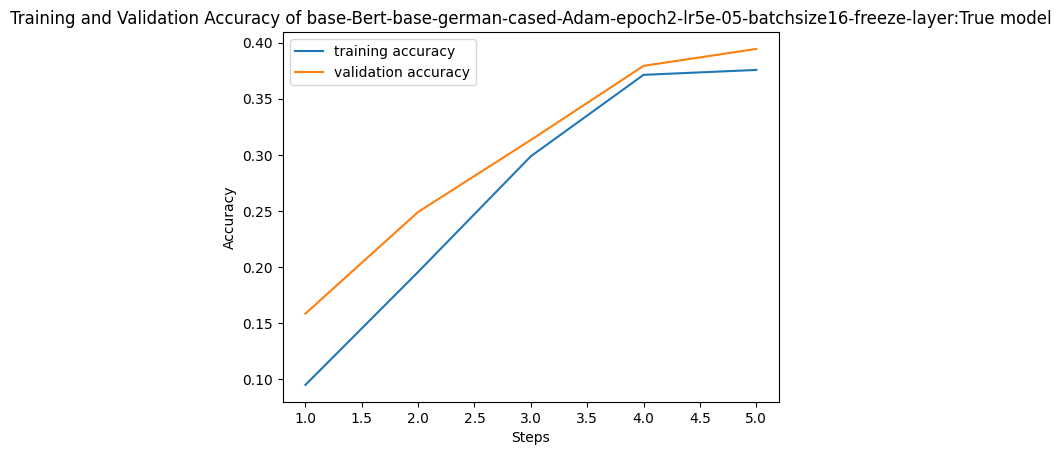

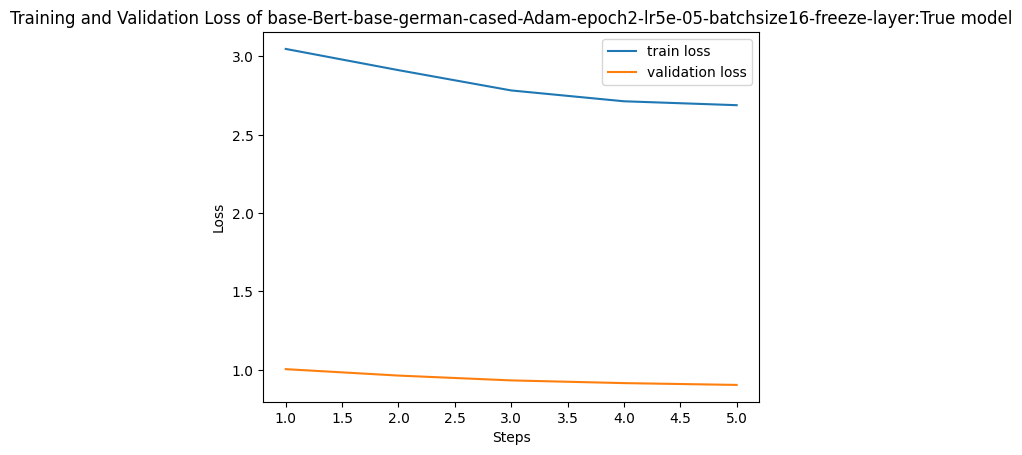

    Label  Correct_preds  Total_preds
0       0              2           28
1       1             28           28
2       2             17           22
3       3              4           24
4       4             24           26
5       5             19           24
6       6              1           24
7       7              0           24
8       8             17           27
9       9              0           24
10     10             18           23
11     11              9           20
12     12              0           20
13     13              4           28
14     14             12           24
15     15              8           29
16     16             25           25
17     17              0           21
18     18              0           18
19     19              5           26
20     20             16           26
21     21              0           19



╒═══════════════════════════════════════════════════════════════════════════════╤══════════╤═══════════╤════════╤══════════

In [17]:
'''will run both models (with custom head and without custom head and freeze all layers except classification layers'''

trained_models_file = 'trained_models.txt'
best_params_dict_path = 'best_params.json'

#df = pickle.load(open('dataset/230130_SmallOberkategorie.pickle', 'rb'))
df = pd.read_pickle("gs://transformer-textclassification/230130_testdata.pickle")
label_names = df['labels'].unique()
# label_names

X = df[['text']]
y = df['labels']
X_train, X_val, y_train, y_val = split_df(X, y)

custom_head = False #when false the model without custom head is loaded
freeze_layers = True
optimizers = [Adam]
learning_rates = [5e-5]
epochs = [2]
batch_sizes = [16]

configs =     {'custom_head': custom_head, 'freeze_layers': freeze_layers,
               'optimizers': optimizers, 'epochs': epochs, 'batch_sizes': batch_sizes,
               'learning_rates': learning_rates, 'val_steps':100}
dataset = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val}

models = [
    'Bert-base-german-cased', 
#'Dbmdz/bert-base-german-uncased',
#'Deepset/gbert-base',
#'Xlm-roberta-base',
#'Uklfr/gottbert-base'
]

# training without custom head
training(models, configs, dataset) #this will train model without custom head and cutom head has to be set to false

### Running model with custom head and freeze layers

Hyperparameters: 
 ('Adam', 'lr5e-05', 'batchsize16', 'epoch2') 

Start Training of custom-Bert-base-german-cased-Adam-epoch2-lr5e-05-batchsize16-freeze-layer:True
Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.2169811320754717 
100/34 val loss: 1.0103008127212525 
100/298 train accuracy: 0.111875 
100/298 train loss: 4.051810669898987 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.24339622641509434 
100/34 val loss: 0.9028229069709778 
100/298 train accuracy: 0.2525 
100/298 train loss: 3.840456840991974 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.30377358490566037 
100/34 val loss: 0.8105456399917602 
100/298 train accuracy: 0.2805259862241703 
100/298 train loss: 3.5237457156181335 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.3433962264150943 
100/34 val loss: 0.753482917547226 
100/298 train accuracy: 0.3525 
100/298 train loss: 3.3006578874588013 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.41509433962264153 
100/34 val loss: 0.7212486672401428 
100/298 train accuracy: 0.350625 
100/298 train loss: 3.2040268528461455 
0.41509433962264153


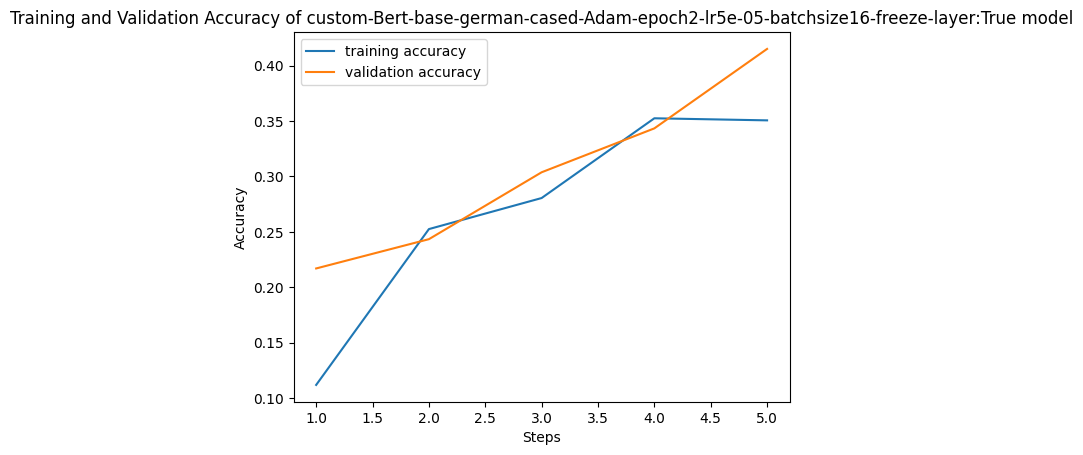

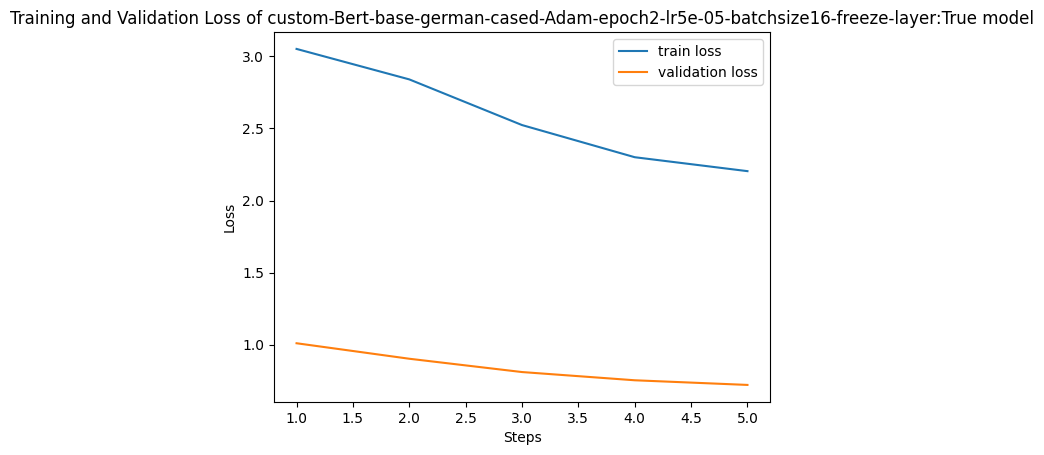

    Label  Correct_preds  Total_preds
0       0             10           28
1       1             28           28
2       2             17           22
3       3             11           24
4       4             25           26
5       5              0           24
6       6              2           24
7       7              0           24
8       8             16           27
9       9              0           24
10     10             21           23
11     11              4           20
12     12              0           20
13     13              4           28
14     14             16           24
15     15              8           29
16     16             25           25
17     17              0           21
18     18              3           18
19     19              8           26
20     20             16           26
21     21              6           19



╒═════════════════════════════════════════════════════════════════════════════════╤══════════╤═══════════╤════════╤════════

In [18]:
configs['custom_head'] = True
training(models, configs, dataset)

## Hyperparameter Tuning

### Running model without custom head and unfreeze layers

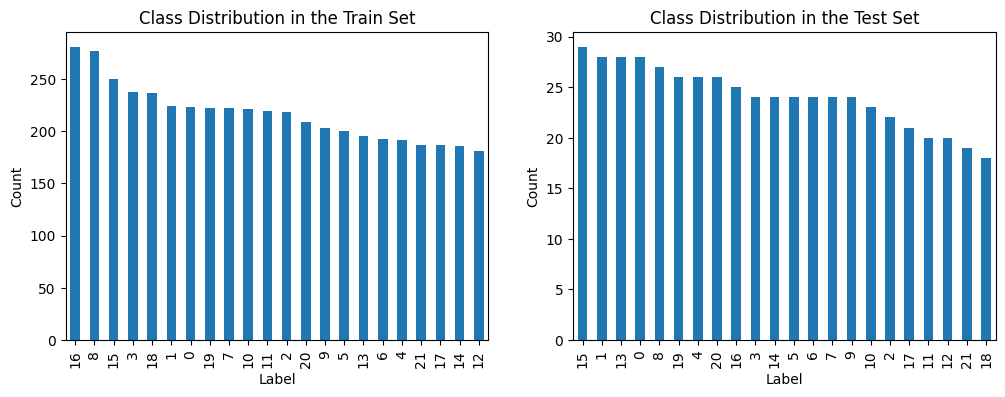

Hyperparameters: 
 ('Adam', 'lr0.0005', 'batchsize16', 'epoch2') 

Start Training of base-Bert-base-german-cased-Adam-epoch2-lr0.0005-batchsize16-freeze-layer:False
Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04905660377358491 
100/34 val loss: 1.0667647576332093 
100/298 train accuracy: 0.05625 
100/298 train loss: 4.299307847023011 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.033962264150943396 
100/34 val loss: 1.0791636896133423 
100/298 train accuracy: 0.059375 
100/298 train loss: 4.179437735080719 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.068123528957367 
100/298 train accuracy: 0.051972448340638695 
100/298 train loss: 4.1438021779060366 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.045283018867924525 
100/34 val loss: 1.0628949093818665 
100/298 train accuracy: 0.055625 
100/298 train loss: 4.129792749881744 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.0564118075370788 
100/298 train accuracy: 0.046875 
100/298 train loss: 4.106583647727966 
0.04716981132075472


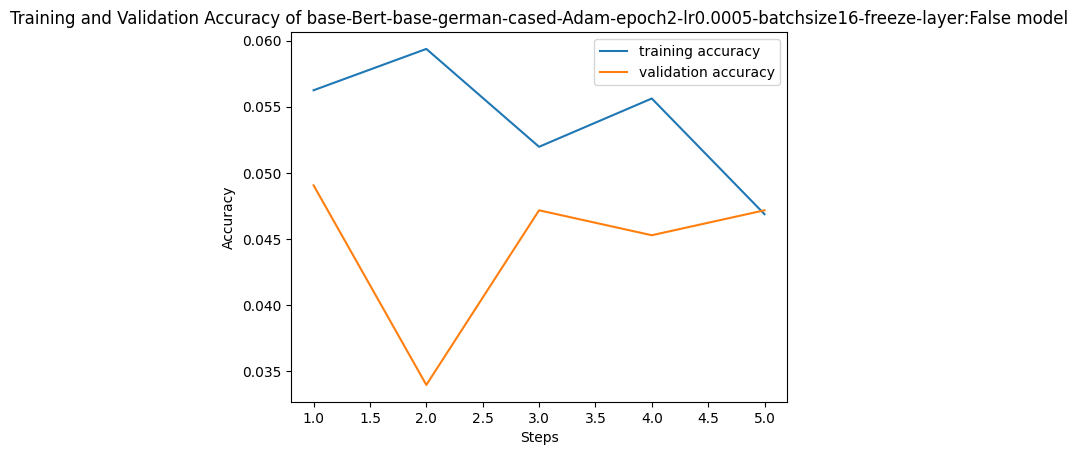

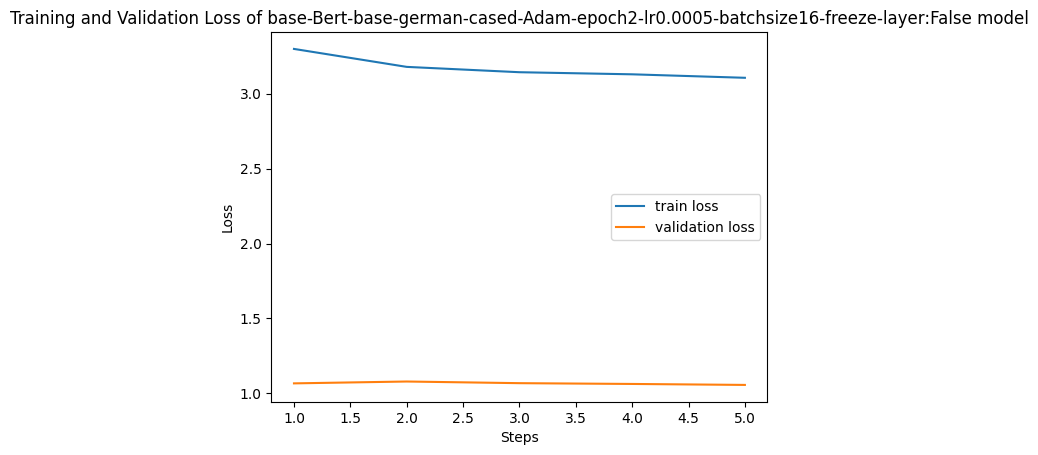

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              0           28
2       2              0           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10              0           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              0           29
16     16             25           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20              0           26
21     21              0           19



Hyperparameters: 
 ('Adam', 'lr0.0005', 'batchsize16', 'epoch5') 

Start Training of base-Bert-base-german-cased-Adam-epoch

Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.065380780696869 
100/298 train accuracy: 0.060625 
100/298 train loss: 4.167939128875732 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.033962264150943396 
100/34 val loss: 1.0707816767692566 
100/298 train accuracy: 0.04625 
100/298 train loss: 4.141873478889465 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.066103219985962 
100/298 train accuracy: 0.042579837194740136 
100/298 train loss: 4.126768805980682 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.045283018867924525 
100/34 val loss: 1.0607492566108703 
100/298 train accuracy: 0.058125 
100/298 train loss: 4.127156057357788 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.0617313313484191 
100/298 train accuracy: 0.039375 
100/298 train loss: 4.113829989433288 
Epoch:  3


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.0594992089271544 
100/298 train accuracy: 0.041953663118346904 
100/298 train loss: 4.110663039684296 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.0557648706436158 
100/298 train accuracy: 0.055 
100/298 train loss: 4.1073756980896 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.0509433962264151 
100/34 val loss: 1.0591797947883606 
100/298 train accuracy: 0.045625 
100/298 train loss: 4.105971543788909 
Epoch:  4


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.0509433962264151 
100/34 val loss: 1.0546307921409608 
100/298 train accuracy: 0.059486537257357544 
100/298 train loss: 4.099902338981629 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.045283018867924525 
100/34 val loss: 1.0559089636802674 
100/298 train accuracy: 0.049375 
100/298 train loss: 4.098119206428528 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.033962264150943396 
100/34 val loss: 1.0548824286460876 
100/298 train accuracy: 0.039375 
100/298 train loss: 4.102093827724457 
Epoch:  5


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.05492271900177 
100/298 train accuracy: 0.06261740763932373 
100/298 train loss: 4.0890255594253535 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.04716981132075472 
100/34 val loss: 1.0557292556762696 
100/298 train accuracy: 0.0575 
100/298 train loss: 4.089431278705597 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.05471698113207547 
100/34 val loss: 1.0522031307220459 
100/298 train accuracy: 0.051875 
100/298 train loss: 4.088723220825195 
0.05471698113207547


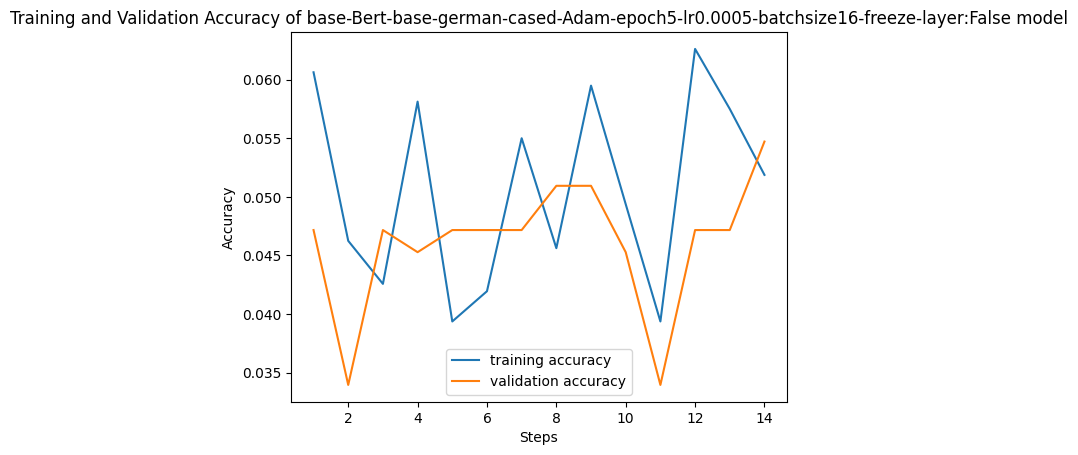

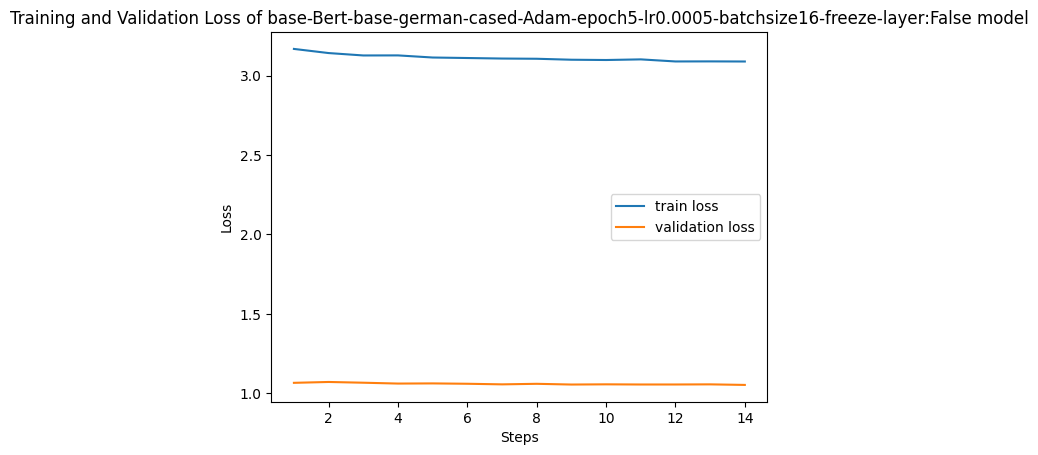

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              0           28
2       2              0           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10              0           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15             29           29
16     16              0           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20              0           26
21     21              0           19



╒═════════════════════════════════════════════════════════════════════════════════╤══════════╤═══════════╤════════╤════════

In [19]:
trained_models_file = 'trained_models.txt'
best_params_dict_path = 'best_params.json'

#df = pickle.load(open('dataset/230130_SmallOberkategorie.pickle', 'rb'))
df = pd.read_pickle("gs://transformer-textclassification/230130_testdata.pickle")
label_names = df['labels'].unique()
# label_names

X = df[['text']]
y = df['labels']
X_train, X_val, y_train, y_val = split_df(X, y)

custom_head = False
freeze_layers = False
optimizers = [Adam]
learning_rates = [5e-4]
epochs = [2, 5]
batch_sizes = [16]

configs =     {'custom_head': custom_head, 'freeze_layers': freeze_layers,
               'optimizers': optimizers, 'epochs': epochs, 'batch_sizes': batch_sizes,
               'learning_rates': learning_rates, 'val_steps':100}
dataset = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val}

models = [
    'Bert-base-german-cased', 
#'Dbmdz/bert-base-german-uncased',
#'Deepset/gbert-base',
#'Xlm-roberta-base',
#'Uklfr/gottbert-base'
]

# training without custom head
training(models, configs, dataset)



### Running model with custom head and unfreeze layers

In [27]:
# training with custom head
configs['custom_head'] = True
training(models, configs, dataset)

KeyError: 'freeze_layers'

# Testing

In [23]:
def validator(model, test_dataloader):
    model.eval()
    test_label = []
    test_pred = []
    test_loss= 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for step_num, batch_data in tqdm(enumerate(test_dataloader)):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            test_loss += loss.item()
            
            test_label.append(labels.cpu().detach().numpy())
            test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
    
    test_label = np.concatenate(test_label)
    test_pred = np.concatenate(test_pred)
    
    return test_label, test_pred

In [24]:
def testing(models, best_params, configs, dataset):
    
    custom_head = configs['custom_head']
    freeze_layers = True
    X_test, y_test = dataset.values() 
    
    custom_head_label = 'custom' if custom_head else 'base'
    model_function = CustomModel2 if custom_head else CustomModel1

    #dic form store results of all models
    collect_test_results_of_all_model= {
        'Metrics':['accuracy','precision','recall','f1-score', 'MCC']
    }
    
    for model_name in models:
        model_str = str(model_name).replace('/', '-')
        model_identifier = custom_head_label + '-' + model_str
        model_params = best_params[model_identifier]
        optimizer = model_params['optimizer']
        batch_size = model_params['batch_size']
        learning_rate = model_params['learning_rate']
        num_epochs = model_params['epochs']

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        test_dataloader = preprocess_dataset(model_name, X_test, y_test, batch_size)
        
        
        optimizer_str = str(optimizer).split('.')[-1].split("'")[0]
        epoch_str = 'epoch' + str(num_epochs)
        lr_str = 'lr' + str(learning_rate)
        batch_size_str = 'batchsize' + str(batch_size)
        model_variant = f'{custom_head_label}-{model_str}-{optimizer_str}-{epoch_str}-{lr_str}-{batch_size_str}'
        model_url = 'models/' + model_identifier + '.pth'

        if os.path.exists(model_url): 
            
            print("===========================================")
            print(f"Hyperparameters: \n {optimizer_str, lr_str, batch_size_str, epoch_str} \n")
            print("Start Testing of {}".format(model_variant))
            print("===========================================")
        
        
            model = model_function(checkpoint=model_name, num_labels=len(label_names)).to(device)
            model.load_state_dict(torch.load(model_url))
            test_label, test_pred = validator(model, test_dataloader)

            calculate_classification_reprot(label_names, test_label, test_pred, model_variant)
            plot_confusion_matrix(test_pred, test_label, label_names, False, model_variant)
            
            collect_test_results_of_all_model[model_variant] = get_evaluation_results(test_label, test_pred)
    
    metrics_data_frame = pd.DataFrame.from_dict(collect_test_results_of_all_model, orient='index')
    return metrics_data_frame

<span style='color:red'>P3<span>

In [32]:
# df = pickle.load(open('path of the test set.pickle', 'rb'))

df = pd.read_pickle("gs://transformer-textclassification/data_for_testing.pickle")
X = df[['text']] #X_val # change with df['text'] for test text
y = df['labels'] #y_val # change with df['label'] for test labels

with open("best_params.json", "r") as fp:
    best_prams = json.load(fp)

custom_head = False # custom_head = True means the model with custom heads will be loaded; if False the base model (no custom head) will be loaded
# freeze_layers = False
dataset = {'X_test': X, 'y_test': y}
configs =     {'custom_head': custom_head}

models = [
    'Bert-base-german-cased' #change this to change the model type
]

metrics_data_frame = testing(models, best_prams, configs, dataset)
print("\n\n")
metrics_data_frame

Hyperparameters: 
 ('Adam', 'lr0.0005', 'batchsize16', 'epoch5') 

Start Testing of base-Bert-base-german-cased-Adam-epoch5-lr0.0005-batchsize16


0it [00:00, ?it/s]

classifiation report of base-Bert-base-german-cased-Adam-epoch5-lr0.0005-batchsize16 model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00 

,0,1,2,3,4
Metrics,accuracy,precision,recall,f1-score,MCC
base-Bert-base-german-cased-Adam-epoch5-lr0.0005-batchsize16,0.0578,0.0026,0.0455,0.005,0.0


## check mismatches

In [33]:
label_df = pd.read_csv('label_dict.csv')
keys = label_df['Id']
label = label_df['Product']
label_dict = dict(zip(keys, label))

In [34]:
def unit_testing(model_name, best_params, configs, test_dataloader):
    custom_head = configs['custom_head']
#     freeze_layers = configs['freeze_layers']
    
    custom_head_label = 'custom' if custom_head else 'base'
    model_function = CustomModel2 if custom_head else CustomModel1
    X, y = dataset.values() 
    
    model_str = str(model_name).replace('/', '-')
    model_identifier = custom_head_label + '-' + model_str
    model_params = best_params[model_identifier]
    optimizer = model_params['optimizer']
    batch_size = model_params['batch_size']
    learning_rate = model_params['learning_rate']
    num_epochs = model_params['epochs']
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_dataloader = preprocess_dataset(model_name, X, y, batch_size)
    
    optimizer_str = str(optimizer).split('.')[-1].split("'")[0]
    epoch_str = 'epoch' + str(num_epochs)
    lr_str = 'lr' + str(learning_rate)
    batch_size_str = 'batchsize' + str(batch_size)
    model_variant = f'{custom_head_label}-{model_str}-{optimizer_str}-{epoch_str}-{lr_str}-{batch_size_str}'
    model_url = 'models/' + model_identifier + '.pth'
    
    
    if os.path.exists(model_url):

        model = model_function(checkpoint=model_name, num_labels=len(label_names)).to(device)
        model.load_state_dict(torch.load(model_url))
        test_label, test_pred = validator(model, test_dataloader)

        return test_label, test_pred
    
    return "trained model doesn't exist on path!"


with open("best_params.json", "r") as fp:
    best_prams = json.load(fp)

custom_head = True #put to False if you want to check mismatches from model without custom head
freeze_layers = False
configs = {'custom_head': custom_head, 'freeze_layers': freeze_layers}
dataset = {'X_test': X, 'y_test': y}
model_name = 'Bert-base-german-cased' #change the model name to test another model

test_label, test_pred = unit_testing(model_name, best_prams, configs, dataset)

pred_df = X
pred_df['test_key'] = test_label
pred_df['test_label'] = pred_df['test_key'].replace(label_dict)
pred_df['pred_key'] = test_pred
pred_df['pred_label'] = pred_df['pred_key'].replace(label_dict)

mismatch_df = pred_df[pred_df['test_key'] != pred_df['pred_key']]
mismatch_df.to_csv(f'predictions/{model_name}-incorrect-predictions.csv')
print(mismatch_df.shape)
mismatch_df.head(10)

0it [00:00, ?it/s]

(1469, 5)


,text,test_key,test_label,pred_key,pred_label
2807,<b>PHS-memory 8GB RAM für HP 15-ba027cl - Spei...,15,Pullover,18,Schutzfolien
29884,val_130323_12x54_de<br />Fenster Volant für Ih...,8,Hüllen,16,Puzzle
100108,Modische Umhängetasche von Liebeskind. Die Tas...,6,Halsketten,15,Pullover
10864,Indiana Jones Kingdom of the Crystal Skull,17,Schuhe,10,Kalender
43009,LOOK: Modische Damen Steppjacke mit tollem Mat...,18,Schutzfolien,13,Lampen
20268,sc_115366_175x180_de<br />Gestalten Sie Ihr Ba...,19,Schürzen,14,Ohrringe
102155,kit_116038_de<br />Verändern Sie Ihre Küche mi...,18,Schutzfolien,8,Hüllen
20414,stall_95763_120x180_de<br />Abmessung: 120 cm ...,21,Staubsaugerbeutel,3,Bilder
42049,<p><strong>OnePlus 5 Tasche mit magnetischer L...,21,Staubsaugerbeutel,15,Pullover
84159,blau Synthetik Rieker Businesschuh Blau 14023001,9,Jacken,18,Schutzfolien


In [36]:
mismatch_df.head(50)

,text,test_key,test_label,pred_key,pred_label
2807,<b>PHS-memory 8GB RAM für HP 15-ba027cl - Spei...,15,Pullover,18,Schutzfolien
29884,val_130323_12x54_de<br />Fenster Volant für Ih...,8,Hüllen,16,Puzzle
100108,Modische Umhängetasche von Liebeskind. Die Tas...,6,Halsketten,15,Pullover
10864,Indiana Jones Kingdom of the Crystal Skull,17,Schuhe,10,Kalender
43009,LOOK: Modische Damen Steppjacke mit tollem Mat...,18,Schutzfolien,13,Lampen
20268,sc_115366_175x180_de<br />Gestalten Sie Ihr Ba...,19,Schürzen,14,Ohrringe
102155,kit_116038_de<br />Verändern Sie Ihre Küche mi...,18,Schutzfolien,8,Hüllen
20414,stall_95763_120x180_de<br />Abmessung: 120 cm ...,21,Staubsaugerbeutel,3,Bilder
42049,<p><strong>OnePlus 5 Tasche mit magnetischer L...,21,Staubsaugerbeutel,15,Pullover
84159,blau Synthetik Rieker Businesschuh Blau 14023001,9,Jacken,18,Schutzfolien


## Attention Wights

In [33]:
with open("best_params.json", "r") as fp:
    best_params = json.load(fp)
    
custom_head = True
freeze_layers = False
configs = {'custom_head': custom_head}

custom_head_label = 'custom' if custom_head else 'base'
model_function = CustomModel2 if custom_head else CustomModel1

# Load pre-trained model and tokenizer
model_name = 'Bert-base-german-cased'
model_str = str(model_name).replace('/', '-')
model_identifier = custom_head_label + '-' + model_str
model_params = best_params[model_identifier]
optimizer = model_params['optimizer']
batch_size = model_params['batch_size']
learning_rate = model_params['learning_rate']
num_epochs = model_params['epochs']

optimizer_str = str(optimizer).split('.')[-1].split("'")[0]
epoch_str = 'epoch' + str(num_epochs)
lr_str = 'lr' + str(learning_rate)
batch_size_str = 'batchsize' + str(batch_size)
model_variant = f'{custom_head_label}-{model_str}-{optimizer_str}-{epoch_str}-{lr_str}-{batch_size_str}'
model_url = 'models/' + model_identifier + '.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = model_function(checkpoint=model_name, num_labels=len(label_names)).to(device)
model.load_state_dict(torch.load(model_url))

# Encode input sentence and get attention masks
input_sentence = "This is a sample input sentence to visualize attention weights."
input_tokens = tokenizer.encode(input_sentence, add_special_tokens=True)
input_tensor = torch.tensor([input_tokens]).to(device)
attention_mask = torch.ones_like(input_tensor).to(device)

# Forward pass through the model to get attention weights
outputs = model(input_tensor, attention_mask=attention_mask)
attentions = outputs[-1]

# Iterate over each layer and head to visualize attention weights
for layer, layer_attentions in enumerate(attentions):
    print(f"Layer {layer+1}:")
    for head, head_attentions in enumerate(layer_attentions):
        print(f"Head {head+1}:")
        for token, weight in zip(input_tokens, head_attentions):
            print(f"{tokenizer.decode([token])} - {weight[0][0].item():.4f}")
        print("\n")

Layer 1:
Head 1:
[CLS] - 0.0302
Th - 0.3363
##is - 0.0463
is - 0.0377
a - 0.0082
sa - 0.4622
##m - 0.0627
##ple - 0.0218
in - 0.0136
##put - 0.5267
sen - 0.0093
##ten - 0.0001


Layer 2:
Head 1:
[CLS] - 0.7273
Th - 0.8083
##is - 0.9989
is - 0.7756
a - 0.9881
sa - 0.7912
##m - 0.6934
##ple - 0.8097
in - 0.8664
##put - 0.3542
sen - 0.0932
##ten - 0.1030


Layer 3:
Head 1:
[CLS] - 0.8528
Th - 0.2691
##is - 0.3116
is - 0.7887
a - 0.8274
sa - 0.1145
##m - 0.5952
##ple - 0.7037
in - 0.3777
##put - 0.2369
sen - 0.7129
##ten - 0.7741


Layer 4:
Head 1:
[CLS] - 0.6241
Th - 0.0763
##is - 0.1515
is - 0.5865
a - 0.1685
sa - 0.3277
##m - 0.6287
##ple - 0.5653
in - 0.0621
##put - 0.4831
sen - 0.4929
##ten - 0.1611


Layer 5:
Head 1:
[CLS] - 0.0268
Th - 0.2936
##is - 0.0676
is - 0.0103
a - 0.1301
sa - 0.3292
##m - 0.0964
##ple - 0.2503
in - 0.1272
##put - 0.0726
sen - 0.7087
##ten - 0.2150


Layer 6:
Head 1:
[CLS] - 0.2436
Th - 0.1362
##is - 0.1088
is - 0.0469
a - 0.1647
sa - 0.2780
##m - 0.0023
##pl